# Simulação da Fronteira Eficiente

### Atividades

1. Ler as bases de preços diários
2. Calcular retornos relativos diários (HP=1)
3. Calcular retorno médio e desvio padrão de cada ativo
4. Calcular matriz de covariância dos ativos
5. Plotar os ativos num gráfico de dispersão: retorno x risco
6. Definir pesos para os ativos e compor em uma carteira. Calcular o retorno e o risco desta carteira
7. Simular diversos conjuntos de pesos aleatoriamente e plotar no gráfico de dispersão estas carteiras

### Dicas

1. Defina funções para ler as bases ao invés de repetir os códigos.
2. Utilize as funções do Pandas - .mean(), .cov(), .shift(), etc.
3. Verifique os resultados a cada cálculo.
4. Para multiplicação matricial, utilize: np.dot()
5. Para simular valores aleatórios, utilize: np.ramdon.ramdon()

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.optimize as solver

In [2]:
# Ler e tratar as bases
def read_infoMoney(file_name):
    df = pd.read_csv('Bases/'+file_name, decimal=',')
    df['DATA'] = pd.to_datetime(df['DATA'])
    df = df[['DATA', 'FECHAMENTO']].set_index('DATA')
    return df

In [3]:
# Dicionário de ativos
assets = {'ABEV3': 'Ambev SA ABEV3 - Histórico InfoMoney.csv',
          'PETR3': 'Petrobras PETR3 - Histórico InfoMoney.csv',
          'MGLU3': 'Magazine Luiza MGLU3 - Histórico InfoMoney.csv',
          'ITUB3': 'Itaú Unibanco ITUB3 - Histórico InfoMoney.csv',
          'ALPA3': 'Alpargatas ALPA3 - Histórico InfoMoney.csv',
          'VALE3': 'Vale S.A. VALE3 - Histórico InfoMoney.csv'}
assets

{'ABEV3': 'Ambev SA ABEV3 - Histórico InfoMoney.csv',
 'PETR3': 'Petrobras PETR3 - Histórico InfoMoney.csv',
 'MGLU3': 'Magazine Luiza MGLU3 - Histórico InfoMoney.csv',
 'ITUB3': 'Itaú Unibanco ITUB3 - Histórico InfoMoney.csv',
 'ALPA3': 'Alpargatas ALPA3 - Histórico InfoMoney.csv',
 'VALE3': 'Vale S.A. VALE3 - Histórico InfoMoney.csv'}

In [4]:
# Consolidando os dados em um único DF
df_assets = pd.DataFrame()

for key, value in assets.items():
    df_assets[key] = read_infoMoney(value)
    
df_assets

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
DATA,,,,,,
2018-12-28,13.99,20.27,5.59,20.52,20.17,40.76
2018-12-27,13.73,19.51,5.38,20.14,19.66,39.56
2018-12-26,13.77,19.62,5.46,19.81,NaN,40.31
2018-12-21,13.80,19.26,5.65,20.01,20.69,40.65
2018-12-20,13.83,19.24,5.50,20.35,20.03,39.81
...,...,...,...,...,...,...
2018-08-01,19.08,14.32,2.42,17.01,20.43,33.20
2018-05-01,19.11,14.10,2.42,17.11,20.38,32.48
2018-04-01,19.04,13.99,2.47,16.99,20.48,31.98


Nota-se alguns dados nulos no DF

In [5]:
# Verificando dados nulos
df_assets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 245 entries, 2018-12-28 to 2018-02-01
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ABEV3   245 non-null    float64
 1   PETR3   245 non-null    float64
 2   MGLU3   245 non-null    float64
 3   ITUB3   245 non-null    float64
 4   ALPA3   208 non-null    float64
 5   VALE3   245 non-null    float64
dtypes: float64(6)
memory usage: 13.4 KB


In [6]:
# Preenchendo os dados nulos em ALPA3 com o dado da data anterior
df_assets['ALPA3'].fillna(method='backfill', inplace=True)
df_assets

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
DATA,,,,,,
2018-12-28,13.99,20.27,5.59,20.52,20.17,40.76
2018-12-27,13.73,19.51,5.38,20.14,19.66,39.56
2018-12-26,13.77,19.62,5.46,19.81,20.69,40.31
2018-12-21,13.80,19.26,5.65,20.01,20.69,40.65
2018-12-20,13.83,19.24,5.50,20.35,20.03,39.81
...,...,...,...,...,...,...
2018-08-01,19.08,14.32,2.42,17.01,20.43,33.20
2018-05-01,19.11,14.10,2.42,17.11,20.38,32.48
2018-04-01,19.04,13.99,2.47,16.99,20.48,31.98


In [7]:
# Calcular retornos
def calc_return(df, hp):
    # retorno simples = preço de hoje / preço de ontem - 1
    # Como o df começa com a data mais recente, colocamos (-hp)
    df_returns = df / df.shift(-hp) - 1
    
    return df_returns

df_returns = calc_return(df_assets, hp=1)
df_returns

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
DATA,,,,,,
2018-12-28,0.018937,0.038954,0.039033,0.018868,0.025941,0.030334
2018-12-27,-0.002905,-0.005607,-0.014652,0.016658,-0.049783,-0.018606
2018-12-26,-0.002174,0.018692,-0.033628,-0.009995,0.000000,-0.008364
2018-12-21,-0.002169,0.001040,0.027273,-0.016708,0.032951,0.021100
2018-12-20,-0.012848,-0.024341,0.005484,0.003947,0.000000,-0.004003
...,...,...,...,...,...,...
2018-08-01,-0.001570,0.015603,0.000000,-0.005845,0.002453,0.022167
2018-05-01,0.003676,0.007863,-0.020243,0.007063,-0.004883,0.015635
2018-04-01,-0.005744,0.008652,0.024896,0.011310,0.002938,0.004082


In [8]:
# Removendo dados nulos
df_returns.dropna(inplace=True)
df_returns

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
DATA,,,,,,
2018-12-28,0.018937,0.038954,0.039033,0.018868,0.025941,0.030334
2018-12-27,-0.002905,-0.005607,-0.014652,0.016658,-0.049783,-0.018606
2018-12-26,-0.002174,0.018692,-0.033628,-0.009995,0.000000,-0.008364
2018-12-21,-0.002169,0.001040,0.027273,-0.016708,0.032951,0.021100
2018-12-20,-0.012848,-0.024341,0.005484,0.003947,0.000000,-0.004003
...,...,...,...,...,...,...
2018-10-01,0.000000,-0.018855,0.012712,0.003578,-0.036179,-0.013906
2018-09-01,-0.003145,0.000000,-0.024793,-0.014109,0.014684,-0.003614
2018-08-01,-0.001570,0.015603,0.000000,-0.005845,0.002453,0.022167


In [9]:
# Cálculo da correlação entre os ativos
correl_matrix = df_returns.corr()
correl_matrix

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
ABEV3,1.000000,0.189090,0.254340,0.365923,0.081239,0.276319
PETR3,0.189090,1.000000,0.310321,0.463541,0.044192,0.242848
MGLU3,0.254340,0.310321,1.000000,0.407140,0.096564,0.193694
ITUB3,0.365923,0.463541,0.407140,1.000000,0.120557,0.186002
ALPA3,0.081239,0.044192,0.096564,0.120557,1.000000,0.005428
VALE3,0.276319,0.242848,0.193694,0.186002,0.005428,1.000000


In [10]:
# Cálculo da covariância entre os ativos
cov_matrix = df_returns.cov()
cov_matrix

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
ABEV3,0.000186,0.000080,0.000106,0.000083,0.000029,0.000078
PETR3,0.000080,0.000953,0.000291,0.000237,0.000036,0.000156
MGLU3,0.000106,0.000291,0.000926,0.000206,0.000077,0.000122
ITUB3,0.000083,0.000237,0.000206,0.000275,0.000052,0.000064
ALPA3,0.000029,0.000036,0.000077,0.000052,0.000688,0.000003
VALE3,0.000078,0.000156,0.000122,0.000064,0.000003,0.000431


In [11]:
# Cálculo do retorno e desvio padrão dos ativos
mi = df_returns.mean() # média
sigma = df_returns.std() # desvio padrão

# Criando um DF com as informações acima
df_mean_std = pd.DataFrame()
df_mean_std['Retorno'] = mi
df_mean_std['Risco'] = sigma
df_mean_std

,Retorno,Risco
ABEV3,-0.001198,0.013636
PETR3,0.002045,0.030865
MGLU3,0.003923,0.030428
ITUB3,0.000960,0.016590
ALPA3,0.000289,0.026235
VALE3,0.001231,0.020749


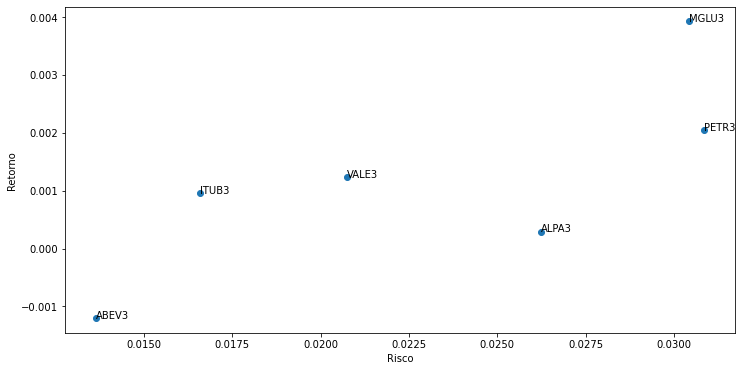

In [12]:
# Gráfico dos ativos: retorno x risco
plt.figure(figsize=(12,6))
plt.scatter(sigma, mi)
plt.xlabel('Risco')
plt.ylabel('Retorno')

# Nomeando os pontos
for i, row in df_mean_std.iterrows():
    plt.annotate(i, (row['Risco'], row['Retorno']))

In [13]:
# Compondo uma carteira
df_carteira = df_mean_std.copy()

# Definindo os pesos
w = [10/100, 2.5/100, 2.5/100, 50/100, 5/100, 30/100]
df_carteira['Peso'] = w
df_carteira

,Retorno,Risco,Peso
ABEV3,-0.001198,0.013636,0.100
PETR3,0.002045,0.030865,0.025
MGLU3,0.003923,0.030428,0.025
ITUB3,0.000960,0.016590,0.500
ALPA3,0.000289,0.026235,0.050
VALE3,0.001231,0.020749,0.300


In [14]:
# Verificando se a soma dos pesos dá 100%
df_carteira['Peso'].sum()

1.0

In [15]:
# Cálculo de retorno e risco da carteira
mi_P = (df_carteira['Peso'] * df_carteira['Retorno']).sum()

# Expressão geral de cálculo (Markowitz) do desvio-padrão de uma carteira de n ativos
sigma_P = np.sqrt(np.dot(df_carteira['Peso'], np.dot(cov_matrix, df_carteira['Peso'])))

print(f'Retorno esperado: {round(mi_P*100, 4)}%, risco: {round(sigma_P*100, 4)}%')

Retorno esperado: 0.0893%, risco: 1.2818%


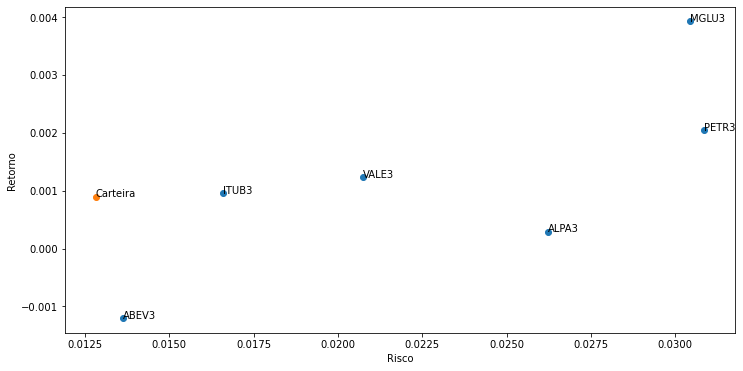

In [16]:
# Gráfico dos ativos e da carteira: retorno x risco

plt.figure(figsize=(12,6))
plt.scatter(sigma, mi)
# Nomeando os pontos
for i, row in df_mean_std.iterrows():
    plt.annotate(i, (row['Risco'], row['Retorno']))
    
plt.scatter(sigma_P, mi_P)
plt.annotate('Carteira', (sigma_P, mi_P))

plt.xlabel('Risco')
plt.ylabel('Retorno');

Essa carteira conseguiu um retorno próximo ao do "ITUB3", mas com o menor risco, em relação a todos os ativos acima.

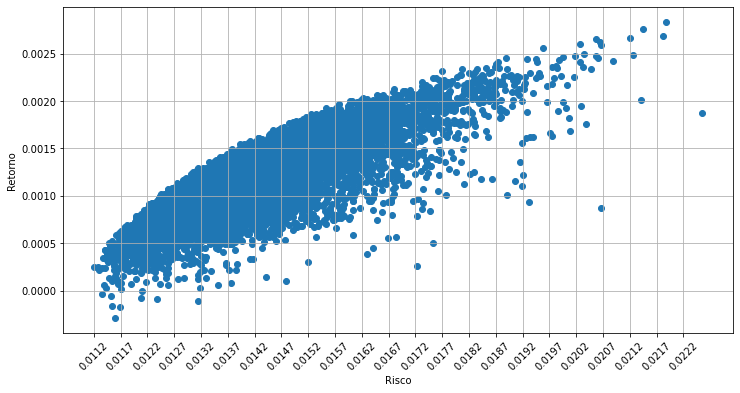

In [17]:
# Simulando carteiras com pesos diferentes
n_ativos = len(df_carteira)

mi_test = []
sigma_test = []

for i in range(10000):
    # Select random weights and normalize to set the sum to 1
    w = np.random.random(n_ativos)
    w = w/np.sum(w)
    
    mi_test.append((w*mi).sum())
    sigma_test.append(np.sqrt(np.dot(w, np.dot(cov_matrix, w))))
    
# Gráfico
plt.figure(figsize=(12,6))    
plt.scatter(sigma_test, mi_test)
plt.xticks(np.arange(min(sigma_test), max(sigma_test), 0.0005), rotation=45)
plt.grid(visible=True)
plt.xlabel('Risco')
plt.ylabel('Retorno');

## Otimização de portfólio

Todo processo de otimização necessita da elaboração de uma função objetiva e da definição de um conjunto de restrições (se houver). Por exemplo, podemos minimizar uma função custo ou maximizar uma função de lucro. No nosso caso, utilizando a teoria de portfólio de Markowitz, desejamos uma das duas coisas:
- minimizar a volatilidade da carteira ou
- maximizar os retornos esperados

Analisaremos adiante cada um dos casos.

### Minimizar a volatilidade

Neste caso, desejamos obter um conjunto de pesos para os ativos da análise, tais que o risco da carteira ponderada por estes pesos seja o menor possível. Podemos escrever este objetivo da seguinte forma:

$$ min F(w) = \sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} $$

Contudo, devemos considerar nossas restrições. A primeira delas refere-se aos valores dos pesos. Por definição, estes devem sempre somar 1. Portanto:

$$\sum_{i=1}^N W_i = 1 $$

ou

$$\sum_{i=1}^N W_i - 1 = 0 $$

A segunda restrição refere-se ao retorno desejado para a carteira, $\mu$. Para que este objetivo seja alcançado, podemos definir:

$$\sum_{i=1}^N W_i r_i = \mu $$

ou

$$\sum_{i=1}^N W_i r_i - \mu = 0 $$

Por fim, precisamos que os pesos possuam valores positivos e sejam menores que 100\%:

$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

O que o cálculo numérico realiza é uma busca para encontrar o melhor conjunto de pesos para cada ativo que garanta que as restrições são respeitadas e que se tenha o menor risco possível.

---

Biblioteca Python utilizada para otimização:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

---


In [18]:
# Definindo função objetivo
def f_obj_min_risk(w):
    return np.sqrt(np.dot(w, np.dot(cov_matrix, w)))

# Definindo valor inicial
w_ini = np.array([1/len(mi)]* len(mi)) 

In [19]:
# Definindo o retorno desejado
ret = 0.0015

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
               {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição

# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(w))) 

In [20]:
result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: 0.013739485026429158
     jac: array([0.00559057, 0.01576803, 0.02120025, 0.01186914, 0.01034408,
       0.01292154])
 message: 'Optimization terminated successfully'
    nfev: 113
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.01487254e-19, 3.22952155e-02, 1.78853741e-01, 3.29297759e-01,
       1.58542782e-01, 3.01010502e-01])

In [21]:
pesos = [round(w*100, 2) for w in result.x]
print(f'Pesos (%): {pesos}\nRisco portfólio (%): {round(result.fun*100,2)}')

Pesos (%): [0.0, 3.23, 17.89, 32.93, 15.85, 30.1]
Risco portfólio (%): 1.37


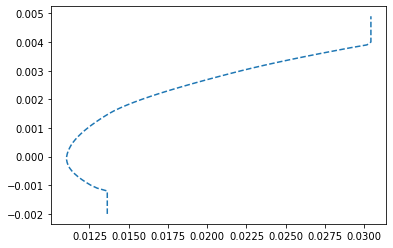

In [22]:
# Simulando para diversos retornos (buscando a fronteira eficiente)
ret_range = np.arange(-0.002, 0.005, 0.0001)
sigma_sim = []

for ret in ret_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição
    
    result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
    sigma_sim.append(result.fun)
    
plt.plot(sigma_sim, ret_range, '--');

### Maximizar o retorno
Neste caso, fixamos a volatilidade desejada $\sigma_P$ e definimos a função objetivo para ampliar os retornos calculados a partir dos pesos. O problema de otimização pode ser rezumido por:

$$ max F(w) = \sum_{i=1}^N W_i r_i $$

Sujeito a:

$$\sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} = \sigma_P $$
$$\sum_{i=1}^N W_i - 1 = 0 $$
$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

Nas bibliotecas existentes, os problemas de otimização sempre são descritas como minimização. Mas isto não é um problema, pois podemos simplesmente inverter o sinal da função objetivo:

$$ min F(w) = - \sum_{i=1}^N W_i r_i $$

In [23]:
# Definindo função objetivo
def f_obj_max_ret(w):
    return -((w*mi).sum())

# Definindo valor inicial
w_ini = np.array([1/len(mi)]* len(mi))

In [24]:
# Definindo o risco desejado
risk = 0.01374

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
              {'type': 'eq', 'fun': lambda x: f_obj_min_risk(x) - risk}]

# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(w))) 

In [25]:
# Imprime resultado
result = solver.minimize(f_obj_max_ret, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: -0.001489550289821001
     jac: array([ 0.00119843, -0.0020454 , -0.00392319, -0.00095984, -0.00028871,
       -0.00123058])
 message: 'Optimization terminated successfully'
    nfev: 112
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.0136822 , 0.03890158, 0.17641758, 0.30028959, 0.14144122,
       0.32926783])

In [26]:
pesos = [round(w*100, 2) for w in result.x]
print(f'Pesos (%): {pesos}\nRetorno portfólio (%): {round(abs(result.fun)*100,4)}')

Pesos (%): [1.37, 3.89, 17.64, 30.03, 14.14, 32.93]
Retorno portfólio (%): 0.149


In [27]:
# Simulando para diversos riscos (buscando a fronteira eficiente)
risk_range = np.arange(0.01, 0.025, 0.0001)
mi_sim = []

for risk in risk_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1},
              {'type': 'eq', 'fun': lambda x: f_obj_min_risk(x) - risk}]

    result = solver.minimize(f_obj_max_ret, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
    mi_sim.append(abs(result.fun))

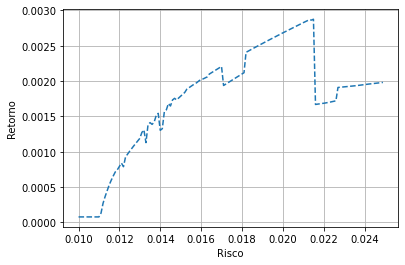

In [28]:
# Gráfico 
plt.plot(risk_range, mi_sim, '--')
plt.grid(visible=True)
plt.xlabel('Risco')
plt.ylabel('Retorno');